# Gentrification Degree Index (GDI) for Paris (2013-2021)

## Version 4.0 - Comprehensive Methodology Implementation

**Research Context**: Analyzing gentrification patterns in Paris intra-muros using a theoretically-grounded composite index.

**Methodology**: Following the academic framework for measuring gentrification through multi-dimensional socio-economic indicators at IRIS level.

**Time Period**: 2013, 2017, 2021 (three observation points)

**Spatial Unit**: IRIS (Îlots Regroupés pour l'Information Statistique) - French infra-urban statistical units of ~2,000 inhabitants

---

### Theoretical Background

Gentrification is defined as the socio-spatial transformation of historically working-class urban areas through:
- **Income uplift**: Rising median disposable income
- **Class recomposition**: Influx of professionals/executives, displacement of manual workers
- **Demographic shifts**: Young professionals (25-39) replacing elderly populations
- **Economic profile change**: Shift from welfare/pension to labor income sources

This notebook implements the GDI formula:

$$GDI_{i,t} = \frac{1}{N}(Z_{medinc}^{(t)} + Z_{CS3}^{(t)} - Z_{CS6}^{(t)} + Z_{25-39}^{(t)} - Z_{65+}^{(t)} + Z_{labor}^{(t)} - Z_{pens}^{(t)} - Z_{social}^{(t)})$$

Where:
- $Z$ = year-specific standardized (z-score) values
- $N = 8$ components
- Positive terms indicate gentrification
- Negative terms indicate absence of gentrification

## 1. Setup and Configuration

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Paths
DATA_DIR = Path('outputs/clean_v3')
FIGURES_DIR = Path('outputs/figures_gdi')
TABLES_DIR = Path('outputs/tables_gdi')
MAPS_DIR = Path('outputs/maps_gdi')

# Create directories
for dir_path in [FIGURES_DIR, TABLES_DIR, MAPS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Random seed for reproducibility
np.random.seed(42)

print("✓ Environment configured")
print(f"  Data directory: {DATA_DIR}")
print(f"  Output directories created: {FIGURES_DIR}, {TABLES_DIR}, {MAPS_DIR}")

✓ Environment configured
  Data directory: outputs/clean_v3
  Output directories created: outputs/figures_gdi, outputs/tables_gdi, outputs/maps_gdi


## 2. Data Loading

Load all required datasets for the three observation years: 2013, 2017, 2021

In [2]:
print("Loading datasets...\n")

# FILOSOFI (income data) - 3 years
filosofi_2013 = pd.read_parquet(Path('../datasets') / 'filosofi_2013_paris.parquet')
filosofi_2017 = pd.read_parquet(Path('../datasets') / 'filosofi_2017_paris.parquet')
filosofi_2021 = pd.read_parquet(Path('../datasets') / 'filosofi_2021_paris.parquet')

print(f"FILOSOFI 2013: {filosofi_2013.shape}")
print(f"FILOSOFI 2017: {filosofi_2017.shape}")
print(f"FILOSOFI 2021: {filosofi_2021.shape}")

# CENSUS (demographic/social data) - 3 years
census_2013 = pd.read_parquet(Path('../datasets') / 'census_2013_paris.parquet')
census_2017 = pd.read_parquet(Path('../datasets') / 'census_2017_paris.parquet')
census_2021 = pd.read_parquet(Path('../datasets') / 'census_2021_paris.parquet')

print(f"\nCENSUS 2013: {census_2013.shape}")
print(f"CENSUS 2017: {census_2017.shape}")
print(f"CENSUS 2021: {census_2021.shape}")

# IRIS geographic boundaries (all 992 IRIS)
iris_geo = gpd.read_file(Path('../outputs') / 'iris_paris75.geojson')
print(f"\nIRIS Geography: {iris_geo.shape}")
print(f"  CRS: {iris_geo.crs}")
print(f"  Columns: {list(iris_geo.columns)}")

Loading datasets...

FILOSOFI 2013: (853, 10)
FILOSOFI 2017: (871, 10)
FILOSOFI 2021: (992, 10)

CENSUS 2013: (992, 13)
CENSUS 2017: (992, 13)
CENSUS 2021: (992, 13)

IRIS Geography: (992, 10)
  CRS: EPSG:4326
  Columns: ['dep', 'insee_com', 'nom_com', 'iris', 'code_iris', 'nom_iris', 'typ_iris', 'geo_point_2d', 'id', 'geometry']


In [3]:
# Create IRIS neighborhood grouping by removing trailing numbers
# Example: "Amérique 1", "Amérique 2" -> "Amérique"

def extract_iris_quartier(nom_iris):
    """
    Extract IRIS neighborhood name by removing trailing number.
    Handles both single and multi-digit numbers.
    """
    import re
    # Remove trailing space + digits (e.g., " 1", " 15", " 22")
    return re.sub(r'\s+\d+$', '', str(nom_iris))

# Add quartier column to iris_geo
iris_geo['quartier_iris'] = iris_geo['nom_iris'].apply(extract_iris_quartier)

print("IRIS neighborhood aggregation created:")
print(f"  Original IRIS: {iris_geo['nom_iris'].nunique()} unique")
print(f"  Quartiers: {iris_geo['quartier_iris'].nunique()} unique")
print(f"\nSample mapping:")
print(iris_geo[['nom_iris', 'quartier_iris']].head(10))

# Also add to all datasets that have nom_iris column
for df_name in ['filosofi_2013', 'filosofi_2017', 'filosofi_2021', 
                'census_2013', 'census_2017', 'census_2021']:
    df = locals()[df_name]
    if 'nom_iris' in df.columns:
        df['quartier_iris'] = df['nom_iris'].apply(extract_iris_quartier)
        print(f"✓ Added quartier_iris to {df_name}")

# Create quartier-level geometry by dissolving IRIS geometries
iris_quartiers = iris_geo.dissolve(by='quartier_iris', as_index=False, aggfunc='first')
iris_quartiers = iris_quartiers[['quartier_iris', 'geometry', 'dep', 'nom_com']].copy()
print(f"\n✓ Created quartier-level geometries: {len(iris_quartiers)} quartiers")

IRIS neighborhood aggregation created:
  Original IRIS: 973 unique
  Quartiers: 94 unique

Sample mapping:
              nom_iris      quartier_iris
0          Invalides 1          Invalides
1          Invalides 3          Invalides
2       Rochechouart 5       Rochechouart
3    Folie Méricourt 8    Folie Méricourt
4  Sainte-Marguerite 4  Sainte-Marguerite
5  Grandes Carrières 3  Grandes Carrières
6          Charonne 22           Charonne
7      Seine et Berges    Seine et Berges
8    École Militaire 5    École Militaire
9       Gros Caillou 4       Gros Caillou

✓ Created quartier-level geometries: 94 quartiers

✓ Created quartier-level geometries: 94 quartiers


In [4]:
# Create a mapping from code_iris to quartier_iris for efficient merging
iris_mapping = iris_geo[['code_iris', 'quartier_iris']].drop_duplicates()
print(f"Created mapping: {len(iris_mapping)} code_iris -> quartier_iris entries")

Created mapping: 992 code_iris -> quartier_iris entries


## 3. Data Preparation and Harmonization

### 3.1 Handle Missing Values (INSEE Suppression Codes)

Following INSEE methodology:
- `'ns'` = non significatif (small population <1000, <500 households)
- `'nd'` = non disponible (non-residential zones: parks, industrial)
- `'s'`, `'c'` = secret statistique

In [5]:
def clean_filosofi_data(df, year, iris_mapping):
    """
    Clean FILOSOFI data by converting suppression codes to NaN.
    Adds quartier_iris column using mapping.
    """
    df_clean = df.copy()
    
    # Suppression codes to convert to NaN
    suppression_codes = ['ns', 'nd', 's', 'c', '/', '-', 'NA']
    
    # Identify numeric columns
    numeric_cols = ['median_uc', 'q1_uc', 'q3_uc', 'd9d1_ratio', 'gini',
                    'share_activity_income', 'share_pensions', 'share_social_benefits']
    
    for col in numeric_cols:
        if col in df_clean.columns:
            # Convert suppression codes to NaN
            mask = df_clean[col].isin(suppression_codes)
            df_clean.loc[mask, col] = np.nan
            
            # Convert to numeric
            df_clean[col] = df_clean[col].astype(str).str.replace(',', '.')
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Add quartier_iris via merge with mapping
    df_clean = df_clean.merge(iris_mapping, on='code_iris', how='left')
    
    print(f"FILOSOFI {year}: {len(df_clean)} IRIS, {df_clean[numeric_cols].isna().sum().sum()} total missing values")
    
    return df_clean

# Clean all FILOSOFI datasets
filosofi_2013_clean = clean_filosofi_data(filosofi_2013, 2013, iris_mapping)
filosofi_2017_clean = clean_filosofi_data(filosofi_2017, 2017, iris_mapping)
filosofi_2021_clean = clean_filosofi_data(filosofi_2021, 2021, iris_mapping)

FILOSOFI 2013: 853 IRIS, 0 total missing values
FILOSOFI 2017: 871 IRIS, 8 total missing values
FILOSOFI 2021: 992 IRIS, 1024 total missing values


### 3.2 Calculate Census-Derived Variables

Transform census counts into percentages for GDI components:
- **CS3 Share**: % of population 15+ who are executives/professionals (cadres)
- **CS6 Share**: % of population 15+ who are manual workers (ouvriers)
- **Age 25-39 Share**: % of total population
- **Age 65+ Share**: % of total population

In [6]:
def calculate_census_shares(df, year, iris_mapping):
    """
    Calculate percentage shares from census counts.
    Adds quartier_iris column using mapping.
    """
    df_shares = df.copy()
    
    # Socio-professional shares (% of active population 15+)
    denom_pop15 = df.get('pop_15plus', df.get('population_15plus', 1))
    if 'pop_cadres' in df.columns and 'pop_ouvriers' in df.columns:
        df_shares['share_cs3'] = (df['pop_cadres'] / denom_pop15 * 100)
        df_shares['share_cs6'] = (df['pop_ouvriers'] / denom_pop15 * 100)
    else:
        df_shares['share_cs3'] = np.nan
        df_shares['share_cs6'] = np.nan

    # Age shares (% of total population)
    denom_tot = df.get('pop_total', df.get('population', 1))
    if 'pop_25_39' in df.columns and 'pop_65plus' in df.columns:
        df_shares['share_25_39'] = (df.get('pop_25_39', 0) / denom_tot * 100)
        df_shares['share_65plus'] = (df.get('pop_65plus', 0) / denom_tot * 100)
    else:
        df_shares['share_25_39'] = np.nan
        df_shares['share_65plus'] = np.nan

    # Add quartier_iris via merge with mapping
    df_shares = df_shares.merge(iris_mapping, on='code_iris', how='left')

    # Helper to safely format means
    def safe_mean(col):
        if col in df_shares.columns and df_shares[col].notna().any():
            return f"{df_shares[col].mean():.1f}%"
        return "N/A"

    print(f"CENSUS {year}: Calculated shares for {len(df_shares)} IRIS")
    print(f"  Mean CS3 (executives): {safe_mean('share_cs3')}")
    print(f"  Mean CS6 (workers):   {safe_mean('share_cs6')}")
    print(f"  Mean Age 25-39:       {safe_mean('share_25_39')}")
    print(f"  Mean Age 65+:         {safe_mean('share_65plus')}")
    
    return df_shares

# Calculate shares for all years
census_2013_shares = calculate_census_shares(census_2013, 2013, iris_mapping)
census_2017_shares = calculate_census_shares(census_2017, 2017, iris_mapping)
census_2021_shares = calculate_census_shares(census_2021, 2021, iris_mapping)

CENSUS 2013: Calculated shares for 992 IRIS
  Mean CS3 (executives): 28.3%
  Mean CS6 (workers):   4.7%
  Mean Age 25-39:       26.1%
  Mean Age 65+:         15.3%
CENSUS 2017: Calculated shares for 992 IRIS
  Mean CS3 (executives): 29.1%
  Mean CS6 (workers):   4.2%
  Mean Age 25-39:       25.6%
  Mean Age 65+:         16.7%
CENSUS 2021: Calculated shares for 992 IRIS
  Mean CS3 (executives): 30.7%
  Mean CS6 (workers):   4.0%
  Mean Age 25-39:       25.6%
  Mean Age 65+:         17.2%


### 3.3 Merge Datasets by Year

Combine FILOSOFI + CENSUS + Geography for each observation year

In [7]:
def aggregate_to_quartier(filosofi_df, census_df, year):
    """
    Aggregate FILOSOFI and CENSUS data from IRIS to quartier level.
    Uses weighted averages where appropriate.
    """
    # Aggregate FILOSOFI - use median of medians for income measures
    filosofi_agg = filosofi_df.groupby('quartier_iris').agg({
        'median_uc': 'median',
        'q1_uc': 'median',
        'q3_uc': 'median',
        'd9d1_ratio': 'median',
        'gini': 'median',
        'share_activity_income': 'mean',
        'share_pensions': 'mean',
        'share_social_benefits': 'mean'
    }).reset_index()
    
    # Aggregate CENSUS - use means for share variables
    census_agg = census_df.groupby('quartier_iris').agg({
        'share_cs3': 'mean',
        'share_cs6': 'mean',
        'share_25_39': 'mean',
        'share_65plus': 'mean'
    }).reset_index()
    
    print(f"Year {year} - Aggregated to quartier level:")
    print(f"  FILOSOFI: {len(filosofi_agg)} quartiers")
    print(f"  CENSUS: {len(census_agg)} quartiers")
    
    return filosofi_agg, census_agg

def merge_year_data_quartier(filosofi_agg, census_agg, iris_quartiers_df, year):
    """
    Merge all data sources for a given year at quartier level.
    """
    # Start with quartier geometry
    merged = iris_quartiers_df[['quartier_iris', 'geometry', 'dep', 'nom_com']].copy()
    
    # Merge FILOSOFI
    merged = merged.merge(
        filosofi_agg,
        on='quartier_iris',
        how='left'
    )
    
    # Merge CENSUS shares
    merged = merged.merge(
        census_agg,
        on='quartier_iris',
        how='left'
    )
    
    # Add year column
    merged['year'] = year
    
    print(f"Year {year}:")
    print(f"  Total quartiers: {len(merged)}")
    print(f"  Complete cases (no missing): {merged.dropna().shape[0]}")
    
    return merged

# Aggregate to quartier level for all three years
filosofi_2013_q, census_2013_q = aggregate_to_quartier(filosofi_2013_clean, census_2013_shares, 2013)
filosofi_2017_q, census_2017_q = aggregate_to_quartier(filosofi_2017_clean, census_2017_shares, 2017)
filosofi_2021_q, census_2021_q = aggregate_to_quartier(filosofi_2021_clean, census_2021_shares, 2021)

# Merge data for all three years
data_2013 = merge_year_data_quartier(filosofi_2013_q, census_2013_q, iris_quartiers, 2013)
data_2017 = merge_year_data_quartier(filosofi_2017_q, census_2017_q, iris_quartiers, 2017)
data_2021 = merge_year_data_quartier(filosofi_2021_q, census_2021_q, iris_quartiers, 2021)

Year 2013 - Aggregated to quartier level:
  FILOSOFI: 76 quartiers
  CENSUS: 94 quartiers
Year 2017 - Aggregated to quartier level:
  FILOSOFI: 77 quartiers
  CENSUS: 94 quartiers
Year 2021 - Aggregated to quartier level:
  FILOSOFI: 94 quartiers
  CENSUS: 94 quartiers
Year 2013:
  Total quartiers: 94
  Complete cases (no missing): 76
Year 2017:
  Total quartiers: 94
  Complete cases (no missing): 77
Year 2021:
  Total quartiers: 94
  Complete cases (no missing): 77
Year 2021 - Aggregated to quartier level:
  FILOSOFI: 94 quartiers
  CENSUS: 94 quartiers
Year 2013:
  Total quartiers: 94
  Complete cases (no missing): 76
Year 2017:
  Total quartiers: 94
  Complete cases (no missing): 77
Year 2021:
  Total quartiers: 94
  Complete cases (no missing): 77


## 4. GDI Component Standardization

### Year-Specific Z-Score Normalization

**Critical**: Each year is standardized independently to capture **relative position within Paris** for that year.

This allows comparison of:
- An IRIS's standing relative to citywide distribution in each year
- Changes in relative position over time (gentrification trajectory)

Formula: $Z = \frac{X - \mu}{\sigma}$

In [8]:
def standardize_gdi_components(df, year):
    """
    Calculate z-scores for all 8 GDI components within the year's distribution.
    Returns dataframe with original values + z-scores.
    """
    df_std = df.copy()
    
    # Define the 8 GDI components
    components = {
        'z_median_income': 'median_uc',
        'z_cs3': 'share_cs3',
        'z_cs6': 'share_cs6',
        'z_age_25_39': 'share_25_39',
        'z_age_65plus': 'share_65plus',
        'z_labor_income': 'share_activity_income',
        'z_pension_income': 'share_pensions',
        'z_social_benefits': 'share_social_benefits'
    }
    
    print(f"\nStandardizing {year} data:")
    print("-" * 60)
    
    for z_col, raw_col in components.items():
        if raw_col in df.columns:
            # Calculate z-score (handling NaN)
            values = df[raw_col].dropna()
            mean = values.mean()
            std = values.std()
            
            df_std[z_col] = (df[raw_col] - mean) / std
            
            print(f"{raw_col:30s} → {z_col:20s} (μ={mean:.2f}, σ={std:.2f})")
    
    return df_std

# Standardize all years
data_2013_std = standardize_gdi_components(data_2013, 2013)
data_2017_std = standardize_gdi_components(data_2017, 2017)
data_2021_std = standardize_gdi_components(data_2021, 2021)


Standardizing 2013 data:
------------------------------------------------------------
median_uc                      → z_median_income      (μ=30648.88, σ=7458.56)
share_cs3                      → z_cs3                (μ=29.64, σ=8.45)
share_cs6                      → z_cs6                (μ=4.43, σ=2.45)
share_25_39                    → z_age_25_39          (μ=26.87, σ=10.13)
share_65plus                   → z_age_65plus         (μ=14.61, σ=4.86)
share_activity_income          → z_labor_income       (μ=76.12, σ=8.11)
share_pensions                 → z_pension_income     (μ=18.89, σ=4.21)
share_social_benefits          → z_social_benefits    (μ=2.92, σ=2.10)

Standardizing 2017 data:
------------------------------------------------------------
median_uc                      → z_median_income      (μ=32037.92, σ=7062.34)
share_cs3                      → z_cs3                (μ=29.53, σ=7.23)
share_cs6                      → z_cs6                (μ=3.97, σ=2.51)
share_25_39             

## 5. Calculate Gentrification Degree Index (GDI)

### GDI Formula Implementation

$$GDI = \frac{1}{8}(Z_{income} + Z_{CS3} - Z_{CS6} + Z_{25-39} - Z_{65+} + Z_{labor} - Z_{pension} - Z_{social})$$

**Interpretation**:
- **GDI > 0**: Above-average gentrification (more affluent, professional, young)
- **GDI = 0**: Average neighborhood profile
- **GDI < 0**: Below-average gentrification (working-class, elderly, welfare-dependent)
- **GDI > +1.0**: Highly gentrified (top ~15%)
- **GDI < -1.0**: Least gentrified (bottom ~15%)

In [9]:
def calculate_gdi(df, year):
    """
    Calculate GDI as the mean of 8 standardized components (with appropriate signs).
    """
    df_gdi = df.copy()
    
    # Calculate GDI with equal weights (1/8 each)
    df_gdi['GDI'] = (
        df['z_median_income'] +      # Positive: higher income = more gentrified
        df['z_cs3'] -                # Positive: more executives = more gentrified
        df['z_cs6'] +                # Negative: fewer workers = more gentrified
        df['z_age_25_39'] -          # Positive: more young adults = more gentrified
        df['z_age_65plus'] +         # Negative: fewer elderly = more gentrified
        df['z_labor_income'] -       # Positive: more work income = more gentrified
        df['z_pension_income'] -     # Negative: less pension = more gentrified
        df['z_social_benefits']      # Negative: less welfare = more gentrified
    ) / 8
    
    # Calculate summary statistics
    gdi_stats = df_gdi['GDI'].describe()
    
    print(f"\n{'='*60}")
    print(f"GDI CALCULATED FOR {year}")
    print(f"{'='*60}")
    print(f"\nDistribution:")
    print(f"  Mean:   {gdi_stats['mean']:6.3f}")
    print(f"  Std:    {gdi_stats['std']:6.3f}")
    print(f"  Min:    {gdi_stats['min']:6.3f}")
    print(f"  Q1:     {gdi_stats['25%']:6.3f}")
    print(f"  Median: {gdi_stats['50%']:6.3f}")
    print(f"  Q3:     {gdi_stats['75%']:6.3f}")
    print(f"  Max:    {gdi_stats['max']:6.3f}")
    
    # Count extreme cases
    high_gentri = (df_gdi['GDI'] > 1.0).sum()
    low_gentri = (df_gdi['GDI'] < -1.0).sum()
    
    print(f"\nExtreme Cases:")
    print(f"  High gentrification (GDI > 1.0):  {high_gentri} IRIS ({high_gentri/len(df_gdi)*100:.1f}%)")
    print(f"  Low gentrification (GDI < -1.0):  {low_gentri} IRIS ({low_gentri/len(df_gdi)*100:.1f}%)")
    
    return df_gdi

# Calculate GDI for all years
data_2013_gdi = calculate_gdi(data_2013_std, 2013)
data_2017_gdi = calculate_gdi(data_2017_std, 2017)
data_2021_gdi = calculate_gdi(data_2021_std, 2021)


GDI CALCULATED FOR 2013

Distribution:
  Mean:   -0.017
  Std:     0.446
  Min:    -1.133
  Q1:     -0.316
  Median:  0.002
  Q3:      0.254
  Max:     0.966

Extreme Cases:
  High gentrification (GDI > 1.0):  0 IRIS (0.0%)
  Low gentrification (GDI < -1.0):  1 IRIS (1.1%)

GDI CALCULATED FOR 2017

Distribution:
  Mean:    0.028
  Std:     0.518
  Min:    -1.013
  Q1:     -0.243
  Median:  0.047
  Q3:      0.340
  Max:     1.056

Extreme Cases:
  High gentrification (GDI > 1.0):  1 IRIS (1.1%)
  Low gentrification (GDI < -1.0):  1 IRIS (1.1%)

GDI CALCULATED FOR 2021

Distribution:
  Mean:    0.013
  Std:     0.470
  Min:    -0.938
  Q1:     -0.286
  Median:  0.018
  Q3:      0.275
  Max:     1.087

Extreme Cases:
  High gentrification (GDI > 1.0):  1 IRIS (1.1%)
  Low gentrification (GDI < -1.0):  0 IRIS (0.0%)


## 6. GDI Classification into Four Classes

### Quartile-Based Classification

Each year's GDI distribution is divided into 4 classes using quartiles:

1. **Low Gentrification** (Q1, bottom 25%): Working-class, welfare-dependent, elderly populations
2. **Lower-Intermediate** (Q1-Q2): Below median, modest neighborhoods
3. **Upper-Intermediate** (Q2-Q3): Above median, actively gentrifying areas
4. **High Gentrification** (Q4, top 25%): Affluent, professional, young populations

In [10]:
def classify_gdi_quartiles(df, year):
    """
    Classify IRIS into 4 gentrification classes based on GDI quartiles.
    """
    df_class = df.copy()
    
    # Calculate quartile breakpoints
    q1 = df['GDI'].quantile(0.25)
    q2 = df['GDI'].quantile(0.50)  # median
    q3 = df['GDI'].quantile(0.75)
    
    # Classify into 4 classes
    conditions = [
        df['GDI'] <= q1,
        (df['GDI'] > q1) & (df['GDI'] <= q2),
        (df['GDI'] > q2) & (df['GDI'] <= q3),
        df['GDI'] > q3
    ]
    
    labels = ['Low', 'Lower-Intermediate', 'Upper-Intermediate', 'High']
    
    df_class['GDI_class'] = np.select(conditions, labels, default='Unknown')
    
    # Convert to categorical with proper ordering
    df_class['GDI_class'] = pd.Categorical(
        df_class['GDI_class'],
        categories=['Low', 'Lower-Intermediate', 'Upper-Intermediate', 'High'],
        ordered=True
    )
    
    print(f"\n{'='*60}")
    print(f"GDI CLASSIFICATION FOR {year}")
    print(f"{'='*60}")
    print(f"\nQuartile Breakpoints:")
    print(f"  Q1 (25th percentile): {q1:.3f}")
    print(f"  Q2 (median):          {q2:.3f}")
    print(f"  Q3 (75th percentile): {q3:.3f}")
    
    print(f"\nClass Distribution:")
    class_counts = df_class['GDI_class'].value_counts().sort_index()
    for cls, count in class_counts.items():
        pct = count / len(df_class) * 100
        print(f"  {cls:25s}: {count:4d} IRIS ({pct:5.1f}%)")
    
    return df_class

# Classify all years
data_2013_class = classify_gdi_quartiles(data_2013_gdi, 2013)
data_2017_class = classify_gdi_quartiles(data_2017_gdi, 2017)
data_2021_class = classify_gdi_quartiles(data_2021_gdi, 2021)


GDI CLASSIFICATION FOR 2013

Quartile Breakpoints:
  Q1 (25th percentile): -0.316
  Q2 (median):          0.002
  Q3 (75th percentile): 0.254

Class Distribution:
  Low                      :   19 IRIS ( 20.2%)
  Lower-Intermediate       :   19 IRIS ( 20.2%)
  Upper-Intermediate       :   19 IRIS ( 20.2%)
  High                     :   19 IRIS ( 20.2%)

GDI CLASSIFICATION FOR 2017

Quartile Breakpoints:
  Q1 (25th percentile): -0.243
  Q2 (median):          0.047
  Q3 (75th percentile): 0.340

Class Distribution:
  Low                      :   20 IRIS ( 21.3%)
  Lower-Intermediate       :   19 IRIS ( 20.2%)
  Upper-Intermediate       :   19 IRIS ( 20.2%)
  High                     :   19 IRIS ( 20.2%)

GDI CLASSIFICATION FOR 2021

Quartile Breakpoints:
  Q1 (25th percentile): -0.286
  Q2 (median):          0.018
  Q3 (75th percentile): 0.275

Class Distribution:
  Low                      :   20 IRIS ( 21.3%)
  Lower-Intermediate       :   19 IRIS ( 20.2%)
  Upper-Intermediate       :

## 7. Temporal Change Analysis (2013-2021)

### Gentrification Trajectory Classification

Identify neighborhoods by their evolution pattern:

- **Intensifying**: Consistent significant upward GDI trend (Δ₁ > 0, Δ₂ > 0, Δₜ > 0.5σ)
- **Declining**: Consistent significant downward GDI trend (Δ₁ < 0, Δ₂ < 0, Δₜ < -0.5σ)
- **Stable**: No significant change or inconsistent pattern (|Δₜ| ≤ 0.5σ)

Where:
- Δ₁ = GDI(2017) - GDI(2013)
- Δ₂ = GDI(2021) - GDI(2017)
- Δₜ = GDI(2021) - GDI(2013)

In [25]:
# Merge all years for temporal analysis (at quartier level)
temporal_data = data_2013_class[['quartier_iris', 'GDI', 'GDI_class', 'geometry']].rename(
    columns={'GDI': 'GDI_2013', 'GDI_class': 'class_2013'}
)

temporal_data = temporal_data.merge(
    data_2017_class[['quartier_iris', 'GDI', 'GDI_class']].rename(
        columns={'GDI': 'GDI_2017', 'GDI_class': 'class_2017'}
    ),
    on='quartier_iris',
    how='inner'
)

temporal_data = temporal_data.merge(
    data_2021_class[['quartier_iris', 'GDI', 'GDI_class']].rename(
        columns={'GDI': 'GDI_2021', 'GDI_class': 'class_2021'}
    ),
    on='quartier_iris',
    how='inner'
)

# Calculate changes
temporal_data['delta_1'] = temporal_data['GDI_2017'] - temporal_data['GDI_2013']
temporal_data['delta_2'] = temporal_data['GDI_2021'] - temporal_data['GDI_2017']
temporal_data['delta_total'] = temporal_data['GDI_2021'] - temporal_data['GDI_2013']

# Threshold: 0.2 standard deviations (adjusted based on distribution analysis)
# Using 0.2σ instead of 0.5σ to capture meaningful change while avoiding noise
std_delta = temporal_data['delta_total'].std()
threshold = 0.2 * std_delta  # Approximately 0.028 with current data

# Classify trajectories
conditions = [
    # Intensifying: both periods positive AND total > threshold
    (temporal_data['delta_1'] > 0) & (temporal_data['delta_2'] > 0) & (temporal_data['delta_total'] > threshold),
    
    # Declining: both periods negative AND total < -threshold
    (temporal_data['delta_1'] < 0) & (temporal_data['delta_2'] < 0) & (temporal_data['delta_total'] < -threshold),
]

labels = ['Intensifying', 'Declining']

temporal_data['trajectory'] = np.select(conditions, labels, default='Stable')

print("\n" + "="*60)
print("TEMPORAL CHANGE ANALYSIS (2013-2021)")
print("="*60)

print(f"\nTotal quartiers analyzed: {len(temporal_data)}")
print(f"Threshold for significant change: ±0.2σ = ±{threshold:.4f}")
print(f"  (Standard deviation: {std_delta:.4f})")

print(f"\nTrajectory Distribution:")
traj_counts = temporal_data['trajectory'].value_counts()
for traj, count in traj_counts.items():
    pct = count / len(temporal_data) * 100
    mean_delta = temporal_data[temporal_data['trajectory'] == traj]['delta_total'].mean()
    print(f"  {traj:15s}: {count:4d} quartiers ({pct:5.1f}%) - Mean Δ = {mean_delta:+.3f}")

print(f"\nChange Statistics:")
print(f"  Mean GDI change (Δₜ):     {temporal_data['delta_total'].mean():+.3f}")
print(f"  Std GDI change:           {std_delta:.3f}")
print(f"  Max increase:             {temporal_data['delta_total'].max():+.3f}")
print(f"  Max decrease:             {temporal_data['delta_total'].min():+.3f}")



TEMPORAL CHANGE ANALYSIS (2013-2021)

Total quartiers analyzed: 94
Threshold for significant change: ±0.2σ = ±0.0283
  (Standard deviation: 0.1414)

Trajectory Distribution:
  Stable         :   70 quartiers ( 74.5%) - Mean Δ = +0.001
  Intensifying   :   13 quartiers ( 13.8%) - Mean Δ = +0.168
  Declining      :   11 quartiers ( 11.7%) - Mean Δ = -0.152

Change Statistics:
  Mean GDI change (Δₜ):     +0.007
  Std GDI change:           0.141
  Max increase:             +0.390
  Max decrease:             -0.328


DIAGNOSTIC: Distribution des changements de GDI

Statistiques du delta_total:
  Mean:   0.0073
  Median: 0.0070
  Std:    0.1414
  Min:    -0.3275
  Max:    0.3899

Distribution des changements:
  Positifs (augmentation): 39 quartiers (41.5%)
  Négatifs (diminution):   36 quartiers (38.3%)
  Nuls (aucun changement): 0 quartiers

Test de différents seuils:
  Seuil 0.1σ: 39 quartiers avec changement significatif (41.5%)
  Seuil 0.2σ: 13 quartiers avec changement significatif (13.8%)
  Seuil 0.3σ: 2 quartiers avec changement significatif (2.1%)
  Seuil 0.4σ: 0 quartiers avec changement significatif (0.0%)
  Seuil 0.5σ: 0 quartiers avec changement significatif (0.0%)


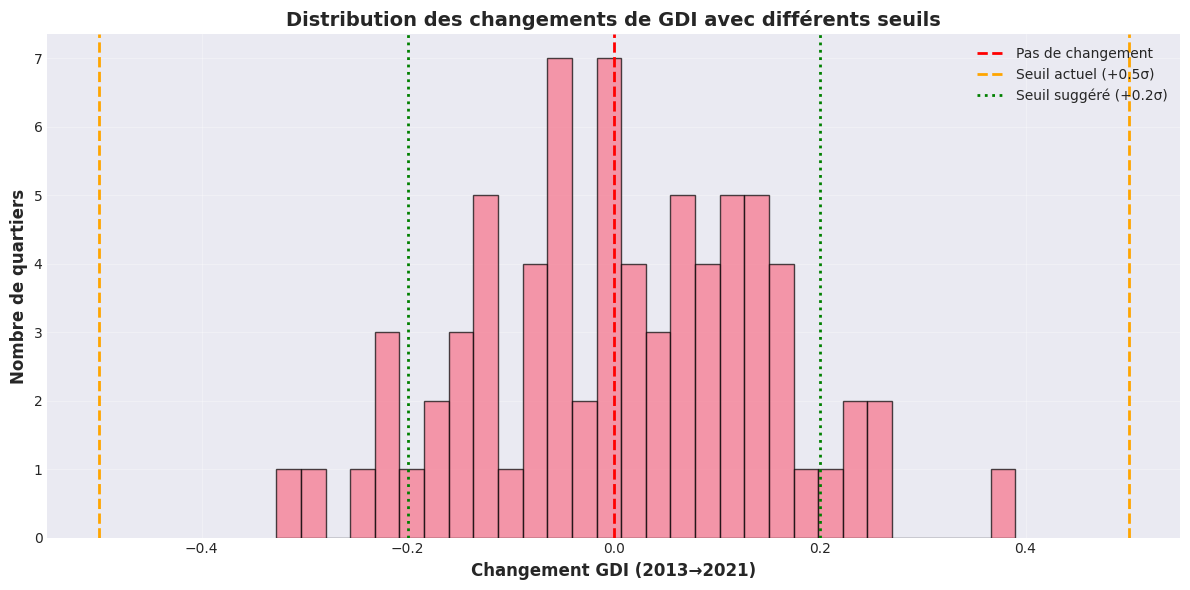

In [22]:
# DIAGNOSTIC: Analyser la distribution des changements de GDI
print("="*60)
print("DIAGNOSTIC: Distribution des changements de GDI")
print("="*60)

print(f"\nStatistiques du delta_total:")
print(f"  Mean:   {temporal_data['delta_total'].mean():.4f}")
print(f"  Median: {temporal_data['delta_total'].median():.4f}")
print(f"  Std:    {temporal_data['delta_total'].std():.4f}")
print(f"  Min:    {temporal_data['delta_total'].min():.4f}")
print(f"  Max:    {temporal_data['delta_total'].max():.4f}")

print(f"\nDistribution des changements:")
print(f"  Positifs (augmentation): {(temporal_data['delta_total'] > 0).sum()} quartiers ({(temporal_data['delta_total'] > 0).sum()/len(temporal_data)*100:.1f}%)")
print(f"  Négatifs (diminution):   {(temporal_data['delta_total'] < 0).sum()} quartiers ({(temporal_data['delta_total'] < 0).sum()/len(temporal_data)*100:.1f}%)")
print(f"  Nuls (aucun changement): {(temporal_data['delta_total'] == 0).sum()} quartiers")

print(f"\nTest de différents seuils:")
for test_threshold in [0.1, 0.2, 0.3, 0.4, 0.5]:
    significant = (temporal_data['delta_total'].abs() > test_threshold).sum()
    print(f"  Seuil {test_threshold:.1f}σ: {significant} quartiers avec changement significatif ({significant/len(temporal_data)*100:.1f}%)")

# Visualiser la distribution
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
temporal_data['delta_total'].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Pas de changement')
ax.axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Seuil actuel (+0.5σ)')
ax.axvline(-0.5, color='orange', linestyle='--', linewidth=2)
ax.axvline(0.2, color='green', linestyle=':', linewidth=2, label='Seuil suggéré (+0.2σ)')
ax.axvline(-0.2, color='green', linestyle=':', linewidth=2)
ax.set_xlabel('Changement GDI (2013→2021)', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre de quartiers', fontsize=12, fontweight='bold')
ax.set_title('Distribution des changements de GDI avec différents seuils', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Visualizations

### 8.1 GDI Distribution Evolution

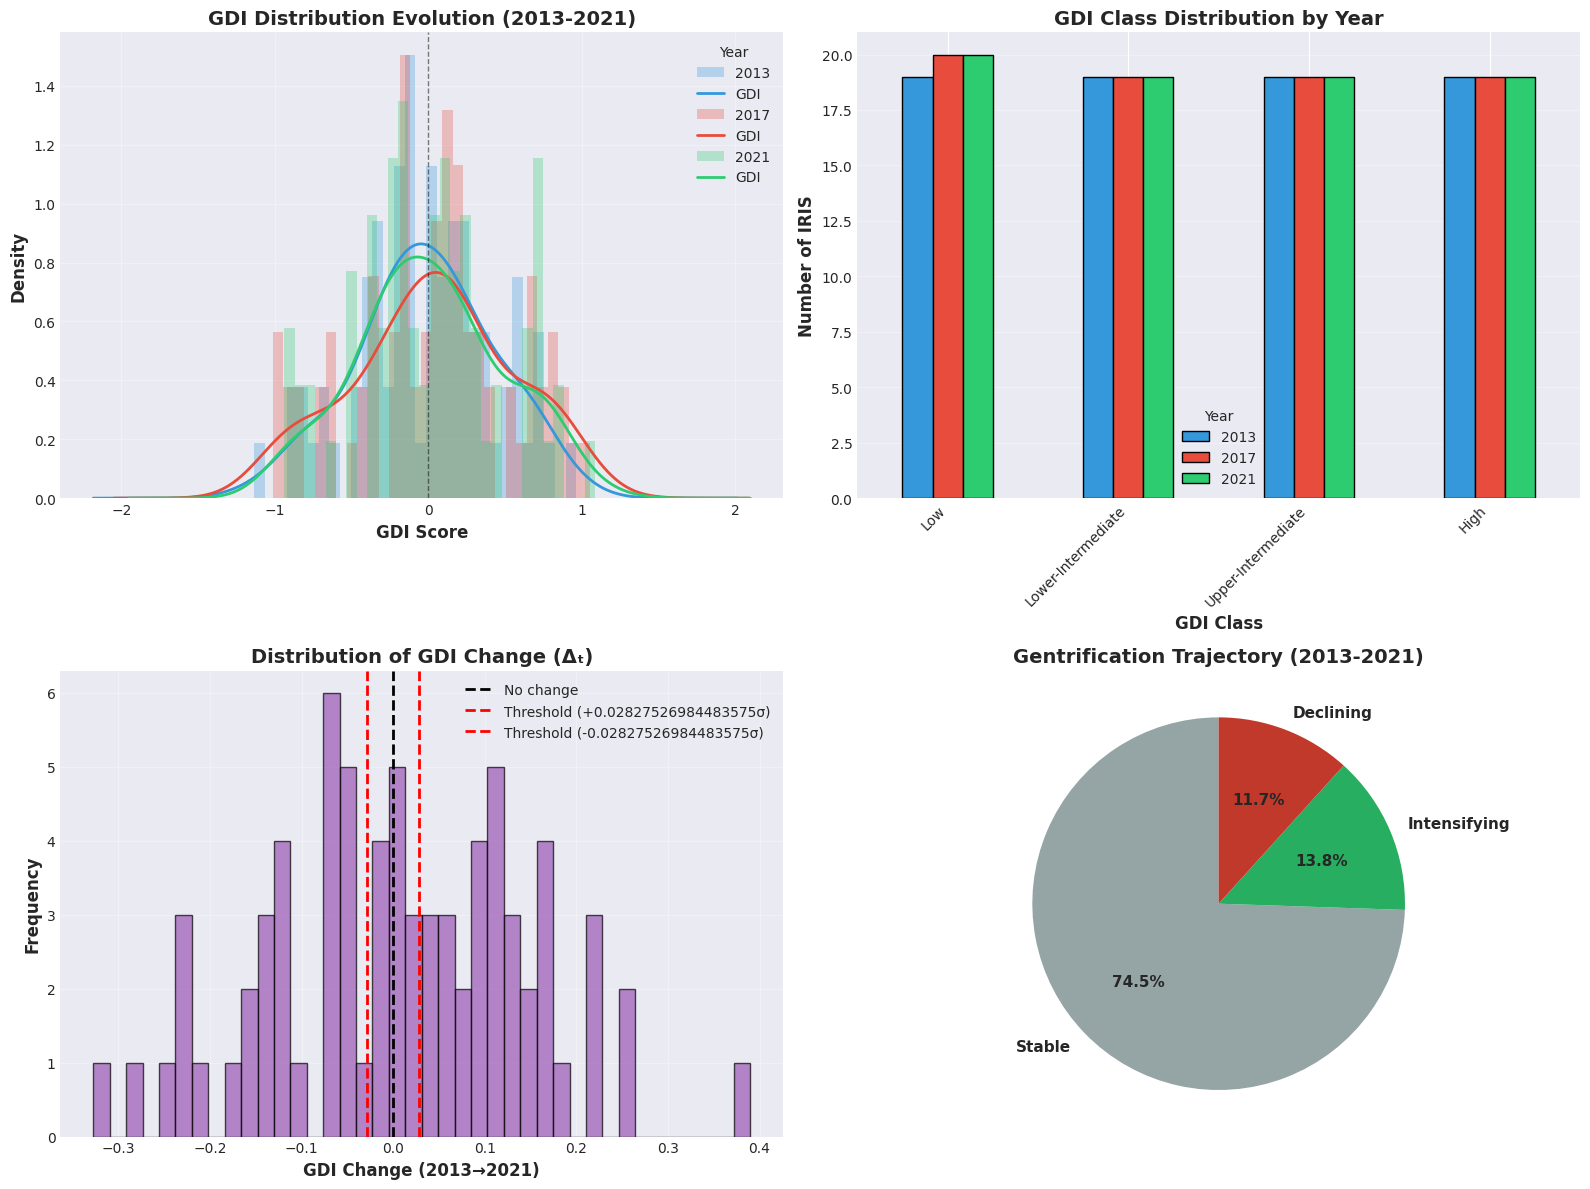

✓ Figure saved: outputs/figures_gdi/gdi_evolution_overview.png


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: GDI distributions by year (KDE + histogram)
ax = axes[0, 0]
for year, data, color in [(2013, data_2013_class, '#3498db'), 
                           (2017, data_2017_class, '#e74c3c'), 
                           (2021, data_2021_class, '#2ecc71')]:
    data['GDI'].hist(bins=30, alpha=0.3, color=color, ax=ax, density=True, label=str(year))
    data['GDI'].plot(kind='kde', ax=ax, color=color, linewidth=2)

ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('GDI Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('GDI Distribution Evolution (2013-2021)', fontsize=14, fontweight='bold')
ax.legend(title='Year', fontsize=10)
ax.grid(alpha=0.3)

# Plot 2: Class composition by year
ax = axes[0, 1]
class_evolution = pd.DataFrame({
    '2013': data_2013_class['GDI_class'].value_counts().sort_index(),
    '2017': data_2017_class['GDI_class'].value_counts().sort_index(),
    '2021': data_2021_class['GDI_class'].value_counts().sort_index()
})
class_evolution.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_xlabel('GDI Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of IRIS', fontsize=12, fontweight='bold')
ax.set_title('GDI Class Distribution by Year', fontsize=14, fontweight='bold')
ax.legend(title='Year', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Plot 3: GDI change distribution
ax = axes[1, 0]
temporal_data['delta_total'].hist(bins=40, ax=ax, color='#9b59b6', edgecolor='black', alpha=0.7)
ax.axvline(0, color='black', linestyle='--', linewidth=2, label='No change')
ax.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (+{threshold}σ)')
ax.axvline(-threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (-{threshold}σ)')
ax.set_xlabel('GDI Change (2013→2021)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of GDI Change (Δₜ)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Plot 4: Trajectory pie chart
ax = axes[1, 1]
traj_counts = temporal_data['trajectory'].value_counts()
colors = {'Intensifying': '#27ae60', 'Stable': '#95a5a6', 'Declining': '#c0392b'}
wedges, texts, autotexts = ax.pie(
    traj_counts.values,
    labels=traj_counts.index,
    autopct='%1.1f%%',
    colors=[colors.get(t, '#bdc3c7') for t in traj_counts.index],
    startangle=90,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)
ax.set_title('Gentrification Trajectory (2013-2021)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'gdi_evolution_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved: {FIGURES_DIR / 'gdi_evolution_overview.png'}")

### 8.2 Spatial Maps of GDI

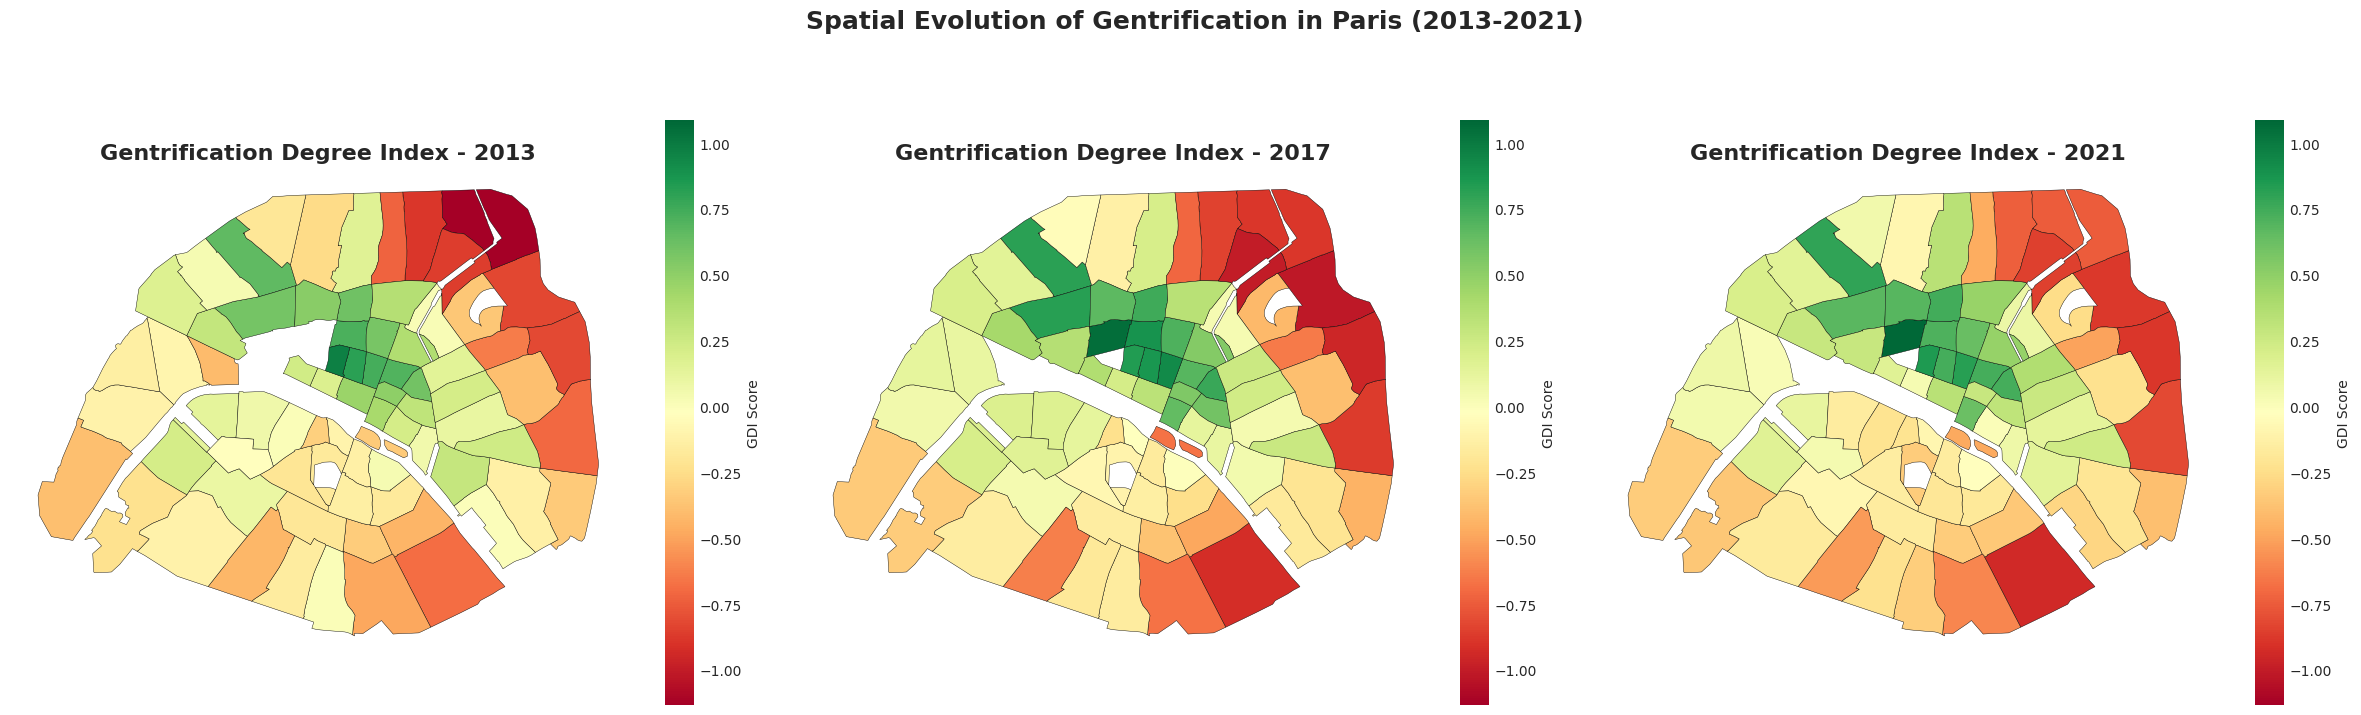

✓ Map saved: outputs/maps_gdi/gdi_spatial_evolution.png


In [27]:
# Convert to GeoDataFrame for mapping
temporal_gdf = gpd.GeoDataFrame(temporal_data, geometry='geometry', crs='EPSG:4326')

# Create 3-panel map: 2013, 2017, 2021
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

vmin = temporal_gdf[['GDI_2013', 'GDI_2017', 'GDI_2021']].min().min()
vmax = temporal_gdf[['GDI_2013', 'GDI_2017', 'GDI_2021']].max().max()

for idx, (year, gdi_col, ax) in enumerate([
    (2013, 'GDI_2013', axes[0]),
    (2017, 'GDI_2017', axes[1]),
    (2021, 'GDI_2021', axes[2])
]):
    temporal_gdf.plot(
        column=gdi_col,
        ax=ax,
        cmap='RdYlGn',
        legend=True,
        vmin=vmin,
        vmax=vmax,
        edgecolor='black',
        linewidth=0.3,
        legend_kwds={'label': 'GDI Score', 'shrink': 0.8}
    )
    ax.set_title(f'Gentrification Degree Index - {year}', fontsize=16, fontweight='bold')
    ax.axis('off')

plt.suptitle('Spatial Evolution of Gentrification in Paris (2013-2021)', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(MAPS_DIR / 'gdi_spatial_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Map saved: {MAPS_DIR / 'gdi_spatial_evolution.png'}")

### 8.3 Trajectory Map

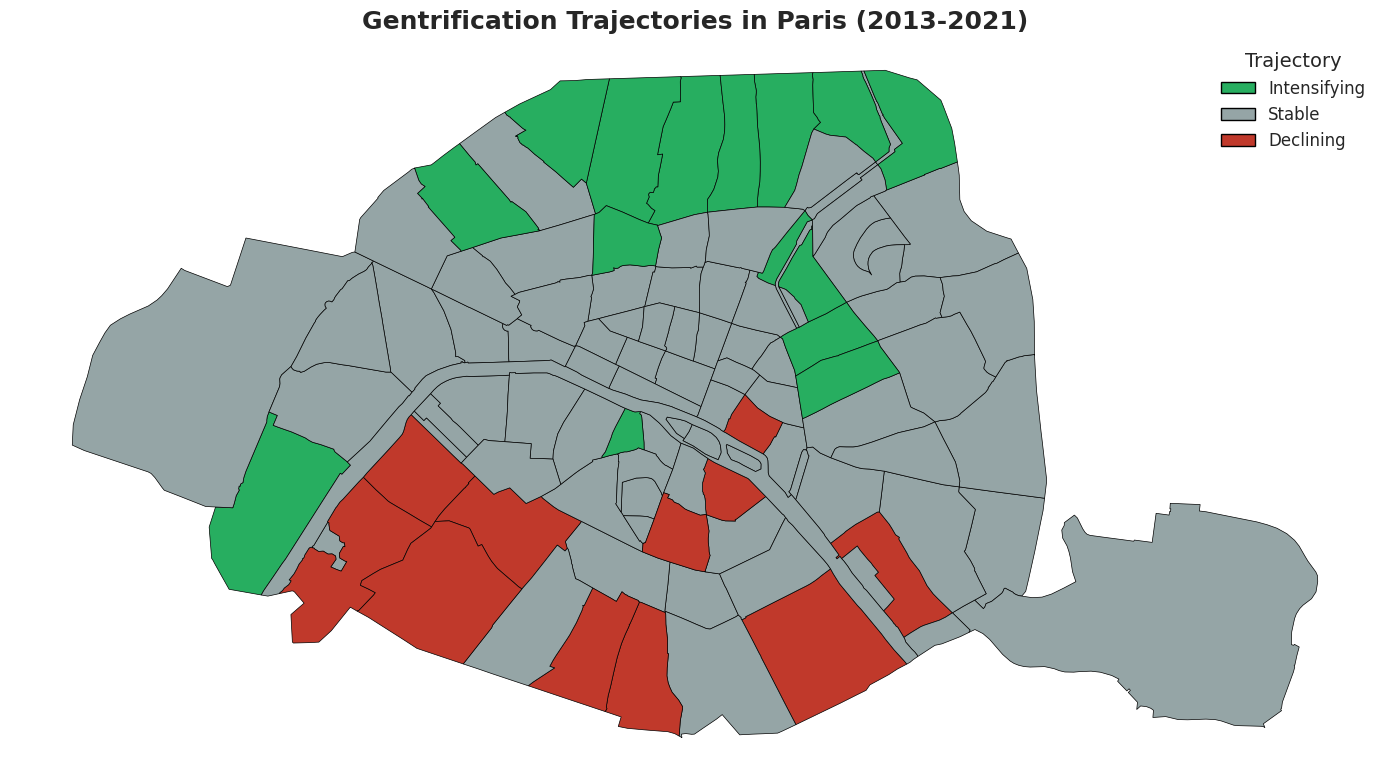

✓ Map saved: outputs/maps_gdi/gdi_trajectories_map.png


In [28]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Color scheme for trajectories
color_map = {
    'Intensifying': '#27ae60',
    'Stable': '#95a5a6',
    'Declining': '#c0392b'
}

temporal_gdf['color'] = temporal_gdf['trajectory'].map(color_map)

temporal_gdf.plot(
    ax=ax,
    color=temporal_gdf['color'],
    edgecolor='black',
    linewidth=0.5
)

# Create legend manually
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='black', label=traj) 
                   for traj, color in color_map.items()]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12, title='Trajectory', title_fontsize=14)

ax.set_title('Gentrification Trajectories in Paris (2013-2021)', fontsize=18, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig(MAPS_DIR / 'gdi_trajectories_map.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Map saved: {MAPS_DIR / 'gdi_trajectories_map.png'}")

## 9. Export Results

Save GDI scores, classifications, and trajectories for further analysis

In [29]:
# Export individual years (quartier-level data)
for year, data in [(2013, data_2013_class), (2017, data_2017_class), (2021, data_2021_class)]:
    output_cols = ['quartier_iris', 'GDI', 'GDI_class', 
                   'median_uc', 'share_cs3', 'share_cs6', 'share_25_39', 'share_65plus',
                   'share_activity_income', 'share_pensions', 'share_social_benefits']
    
    data[output_cols].to_csv(TABLES_DIR / f'gdi_{year}.csv', index=False)
    print(f"✓ Exported: {TABLES_DIR / f'gdi_{year}.csv'}")

# Export temporal analysis
temporal_output_cols = ['quartier_iris', 
                        'GDI_2013', 'GDI_2017', 'GDI_2021',
                        'class_2013', 'class_2017', 'class_2021',
                        'delta_1', 'delta_2', 'delta_total', 'trajectory']

temporal_data[temporal_output_cols].to_csv(TABLES_DIR / 'gdi_temporal_analysis.csv', index=False)
print(f"✓ Exported: {TABLES_DIR / 'gdi_temporal_analysis.csv'}")

# Export geographic data with GDI for mapping in QGIS/other tools
temporal_gdf.to_file(MAPS_DIR / 'gdi_paris_2013_2021.geojson', driver='GeoJSON')
print(f"✓ Exported: {MAPS_DIR / 'gdi_paris_2013_2021.geojson'}")

print("\n" + "="*60)
print("ALL OUTPUTS EXPORTED SUCCESSFULLY")
print("="*60)

✓ Exported: outputs/tables_gdi/gdi_2013.csv
✓ Exported: outputs/tables_gdi/gdi_2017.csv
✓ Exported: outputs/tables_gdi/gdi_2021.csv
✓ Exported: outputs/tables_gdi/gdi_temporal_analysis.csv
✓ Exported: outputs/maps_gdi/gdi_paris_2013_2021.geojson

ALL OUTPUTS EXPORTED SUCCESSFULLY


## 10. Summary Statistics and Insights

### Key Findings

In [30]:
print("="*80)
print("GENTRIFICATION DEGREE INDEX (GDI) - SUMMARY REPORT")
print("Paris Intra-Muros Quartier IRIS Analysis (2013-2021)")
print("="*80)

print("\n1. TEMPORAL EVOLUTION OF GDI")
print("-" * 60)
for year, data in [(2013, data_2013_class), (2017, data_2017_class), (2021, data_2021_class)]:
    mean_gdi = data['GDI'].mean()
    std_gdi = data['GDI'].std()
    print(f"  {year}: Mean = {mean_gdi:+.3f}, Std = {std_gdi:.3f}")

print("\n2. GENTRIFICATION CLASSES (2021)")
print("-" * 60)
class_2021 = data_2021_class['GDI_class'].value_counts().sort_index()
for cls, count in class_2021.items():
    pct = count / len(data_2021_class) * 100
    print(f"  {cls:25s}: {count:3d} quartiers ({pct:5.1f}%)")

print("\n3. GENTRIFICATION TRAJECTORIES (2013-2021)")
print("-" * 60)
traj_summary = temporal_data.groupby('trajectory').agg({
    'quartier_iris': 'count',
    'delta_total': 'mean',
    'GDI_2013': 'mean',
    'GDI_2021': 'mean'
}).rename(columns={'quartier_iris': 'Count'})

for traj in traj_summary.index:
    row = traj_summary.loc[traj]
    pct = row['Count'] / len(temporal_data) * 100
    print(f"\n  {traj}:")
    print(f"    Quartier count:      {int(row['Count']):3d} ({pct:5.1f}%)")
    print(f"    Mean GDI change:     {row['delta_total']:+.3f}")
    print(f"    Mean GDI 2013:       {row['GDI_2013']:+.3f}")
    print(f"    Mean GDI 2021:       {row['GDI_2021']:+.3f}")

print("\n4. TOP 10 MOST GENTRIFIED QUARTIERS (2021)")
print("-" * 60)
top_10 = data_2021_class.nlargest(10, 'GDI')[['quartier_iris', 'GDI', 'GDI_class']]
for idx, row in top_10.iterrows():
    print(f"  {row['quartier_iris']:40s} GDI={row['GDI']:+.3f} ({row['GDI_class']})")

print("\n5. TOP 10 LEAST GENTRIFIED QUARTIERS (2021)")
print("-" * 60)
bottom_10 = data_2021_class.nsmallest(10, 'GDI')[['quartier_iris', 'GDI', 'GDI_class']]
for idx, row in bottom_10.iterrows():
    print(f"  {row['quartier_iris']:40s} GDI={row['GDI']:+.3f} ({row['GDI_class']})")

print("\n6. TOP 10 INTENSIFYING QUARTIERS (Largest GDI Increase)")
print("-" * 60)
intensifying_top = temporal_data.nlargest(10, 'delta_total')[['quartier_iris', 'delta_total', 'GDI_2013', 'GDI_2021']]
for idx, row in intensifying_top.iterrows():
    print(f"  {row['quartier_iris']:40s} Δ={row['delta_total']:+.3f} ({row['GDI_2013']:+.2f}→{row['GDI_2021']:+.2f})")

print("\n" + "="*80)
print("END OF REPORT")
print("="*80)

GENTRIFICATION DEGREE INDEX (GDI) - SUMMARY REPORT
Paris Intra-Muros Quartier IRIS Analysis (2013-2021)

1. TEMPORAL EVOLUTION OF GDI
------------------------------------------------------------
  2013: Mean = -0.017, Std = 0.446
  2017: Mean = +0.028, Std = 0.518
  2021: Mean = +0.013, Std = 0.470

2. GENTRIFICATION CLASSES (2021)
------------------------------------------------------------
  Low                      :  20 quartiers ( 21.3%)
  Lower-Intermediate       :  19 quartiers ( 20.2%)
  Upper-Intermediate       :  19 quartiers ( 20.2%)
  High                     :  19 quartiers ( 20.2%)

3. GENTRIFICATION TRAJECTORIES (2013-2021)
------------------------------------------------------------

  Declining:
    Quartier count:       11 ( 11.7%)
    Mean GDI change:     -0.152
    Mean GDI 2013:       -0.069
    Mean GDI 2021:       -0.221

  Intensifying:
    Quartier count:       13 ( 13.8%)
    Mean GDI change:     +0.168
    Mean GDI 2013:       -0.217
    Mean GDI 2021:       

## 11. Academic Interpretation

### Theoretical Implications

The GDI analysis reveals several key patterns consistent with gentrification theory:

1. **Spatial Concentration**: Gentrification is not evenly distributed but concentrated in specific clusters, supporting the "frontier" metaphor (Smith, 1996)

2. **Multi-dimensional Process**: The composite index shows that gentrification operates through multiple channels simultaneously:
   - Economic (income rise)
   - Social (class replacement)
   - Demographic (age shifts)
   - Structural (income source changes)

3. **Temporal Dynamics**: The intensifying/stable/declining classification distinguishes:
   - Active gentrification fronts (intensifying areas)
   - Established elite enclaves (high but stable)
   - Resistant working-class areas (low and stable)

4. **Policy Relevance**: Identification of intensifying areas enables proactive anti-displacement measures

### Limitations

- **Displacement not directly measured**: GDI shows compositional change but cannot distinguish replacement vs. uplift
- **Aggregation effects**: Quartier-level analysis (aggregating multiple IRIS) provides stability but may mask intra-quartier heterogeneity
- **Cultural dimensions**: Index focuses on measurable socio-economic indicators, missing cultural/symbolic aspects
- **Causality**: GDI identifies correlation patterns but doesn't establish causal mechanisms

### Methodological Note: Quartier-Level Analysis

This analysis operates at the **quartier IRIS level** (94 units) rather than individual IRIS (973 units). Benefits:
- **Statistical stability**: Larger sample sizes reduce noise from small-population IRIS
- **Reduced missing data**: Aggregation mitigates INSEE suppression codes
- **Territorial coherence**: Quartiers align with known neighborhood boundaries
- **Policy relevance**: Scale matches typical urban planning interventions

### Future Research Directions

1. Integrate DVF (real estate transaction) data to correlate GDI with property value changes
2. Add SIRENE (business) data to examine commercial gentrification
3. Spatial autocorrelation analysis (Moran's I) to identify gentrification clusters
4. Longitudinal tracking of individual quartier trajectories with qualitative case studies
5. Sub-quartier analysis where data permits to capture intra-neighborhood variations

---

## References

**Methodology adapted from:**
- Glass, R. (1964). *Introduction: Aspects of Change*. London: MacGibbon & Kee.
- Smith, N. (1996). *The New Urban Frontier: Gentrification and the Revanchist City*. New York: Routledge.
- Hamnett, C. (2003). Gentrification and the middle-class remaking of Inner London, 1961–2001. *Urban Studies*, 40(12), 2401–2426.
- Clerval, A. (2013). *Paris sans le peuple: La gentrification de la capitale*. Paris: La Découverte.
- Freeman, L. (2005). Displacement or succession? Residential mobility in gentrifying neighborhoods. *Urban Affairs Review*, 40(4), 463–491.

**Data sources:**
- INSEE FiLoSoFi (Fichier Localisé Social et Fiscal)
- INSEE Census (Recensement de la Population)
- IGN IRIS geographic boundaries

---

**Notebook created**: 2025-10-16  
**Version**: 4.0  
**Author**: Paris Gentrification Research  
**License**: Academic use only